In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load the data
conn = sqlite3.connect('../../data/raw/master.db')

In [143]:
player_stats_query = """
    WITH team_gameweeks AS (
        -- Assign gameweek numbers to each team's matches
        SELECT 
            match_id,
            team,
            date,
            ROW_NUMBER() OVER (PARTITION BY team ORDER BY date) as gameweek
        FROM (
            -- Get all team matches as home and away
            SELECT 
                match_id,
                home_team as team,
                date
            FROM Match
            UNION ALL
            SELECT 
                match_id,
                away_team as team,
                date
            FROM Match
        ) 
    )

    SELECT 
        pi.match_id,
        pi.player_id,
        pi.name,
        m.date,
        m.season,
        m.competition,
        pi.home_away,
        CASE 
            WHEN pi.home_away = 'H' THEN m.home_team 
            ELSE m.away_team 
        END as team,
        tg.gameweek,
        CAST(pi.started_match AS INTEGER) as started_match,
        pi.minutes,
        COALESCE(s.goals, 0) as goals,
        COALESCE(s.assists, 0) as assists,
        COALESCE(s.shots, 0) as shots,
        COALESCE(s.shots_on_target, 0) as shots_on_target,
        COALESCE(s.xG, 0) as xG,
        COALESCE(s.xA, 0) as xA,
        COALESCE(s.passes_completed, 0) as passes_completed,
        COALESCE(s.passes_attempted, 0) as passes_attempted,
        COALESCE(s.progressive_passes, 0) as progressive_passes,
        COALESCE(s.carries, 0) as carries,
        COALESCE(s.progressive_carries, 0) as progressive_carries,
        COALESCE(s.successful_dribbles, 0) as successful_dribbles,
        COALESCE(s.dribbles_attempted, 0) as dribbles_attempted
    FROM Player_Info pi
    JOIN Match m ON pi.match_id = m.match_id
    JOIN team_gameweeks tg ON 
        tg.match_id = m.match_id AND
        tg.team = CASE 
            WHEN pi.home_away = 'H' THEN m.home_team 
            ELSE m.away_team 
        END
    LEFT JOIN Summary s ON 
        pi.match_id = s.match_id AND 
        pi.player_id = s.player_id
    ORDER BY team, gameweek DESC;
"""

player_stats = pd.read_sql_query(player_stats_query, conn)

player_stats.head()

,match_id,player_id,name,date,season,competition,home_away,team,gameweek,started_match,...,shots_on_target,xG,xA,passes_completed,passes_attempted,progressive_passes,carries,progressive_carries,successful_dribbles,dribbles_attempted
0,2ca0b377,1237c049,Ivane Chegra,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,0,...,0,0.0,0.0,1,3,0,4,1,1,0
1,2ca0b377,1a85bcdb,Mohamed Youssouf,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,14,27,1,18,0,4,1
2,2ca0b377,1e7aea56,Benjamin Leroy,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,8,25,0,6,0,0,0
3,2ca0b377,20e0dd86,Cyrille Bayala,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,16,25,3,23,0,2,0
4,2ca0b377,374fbf7d,Riad Nouri,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,16,19,1,18,0,0,0


In [4]:
match_data_query = """
    WITH team_gameweeks AS (
        -- Assign gameweek numbers to each team's matches
        SELECT 
            match_id,
            team,
            date,
            ROW_NUMBER() OVER (PARTITION BY team ORDER BY date) as gameweek
        FROM (
            -- Get all team matches as home and away
            SELECT 
                match_id,
                home_team as team,
                date
            FROM Match
            UNION ALL
            SELECT 
                match_id,
                away_team as team,
                date
            FROM Match
        ) 
    ),

    match_data AS (
        SELECT 
            m.match_id,
            m.date,
            m.season,
            m.competition,
            m.home_team,
            m.away_team,
            htg.gameweek as home_gameweek,
            atg.gameweek as away_gameweek,
            m.home_xG,
            m.away_xG,
            m.home_goals,
            m.away_goals,
            pi.player_id,
            pi.name,
            pi.home_away
        FROM Match m
        INNER JOIN team_gameweeks htg on m.match_id = htg.match_id and m.home_team = htg.team
        INNER JOIN team_gameweeks atg on m.match_id = atg.match_id and m.away_team = atg.team
        INNER JOIN Player_Info pi on m.match_id = pi.match_id
        where pi.started_match = 1
        and m.competition='Premier_League'
    )

    SELECT * FROM match_data
"""

match_data = pd.read_sql_query(match_data_query, conn)

match_data.head()

,match_id,date,season,competition,home_team,away_team,home_gameweek,away_gameweek,home_xG,away_xG,home_goals,away_goals,player_id,name,home_away
0,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,16380240,Mesut Özil,H
1,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,3201b03d,Danny Simpson,A
2,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,38c7feef,Alex Oxlade-Chamberlain,H
3,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,3935e52e,Sead Kolašinac,H
4,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,45963054,Jamie Vardy,A


In [78]:
match_events = match_data.drop(columns=["name", "player_id", "home_away"]).drop_duplicates()

In [87]:
# Create home team records
home_team_records = match_events[['home_team', 'home_gameweek', 'home_xG', 'home_goals']].rename(
    columns={
        'home_team': 'team_name',
        'home_gameweek': 'gameweek', 
        'home_xG': 'xg',
        'home_goals': 'goals'
    }
)

# Create away team records 
away_team_records = match_events[['away_team', 'away_gameweek', 'away_xG', 'away_goals']].rename(
    columns={
        'away_team': 'team_name',
        'away_gameweek': 'gameweek',
        'away_xG': 'xg', 
        'away_goals': 'goals'
    }
)

# Combine home and away records
team_gameweek_stats = pd.concat([home_team_records, away_team_records])

team_gameweek_stats = team_gameweek_stats.sort_values(by=["team_name", "gameweek"], ascending=[True, False]).drop_duplicates().reset_index()

team_gameweek_stats['rolling_goals'] = (team_gameweek_stats
    .sort_values('gameweek')
    .groupby('team_name')['goals']
    .transform(lambda x: x.rolling(window=2, min_periods=1).mean().shift(1))
)

team_gameweek_stats['rolling_xg'] = (team_gameweek_stats
    .sort_values('gameweek')
    .groupby('team_name')['xg']
    .transform(lambda x: x.rolling(window=2, min_periods=1).mean().shift(1))
)

team_gameweek_stats[team_gameweek_stats["team_name"] == "Arsenal"].sort_values(by=["gameweek"], ascending=False).head(11)

,index,team_name,gameweek,xg,goals,rolling_goals,rolling_xg
0,60467,Arsenal,275,0.9,2,1.5,1.75
1,60181,Arsenal,274,0.7,0,3.5,3.60
2,59917,Arsenal,273,2.8,3,3.0,2.55
3,59653,Arsenal,272,4.4,4,1.5,0.70
4,59587,Arsenal,271,0.7,2,1.0,1.40
5,59345,Arsenal,270,0.7,1,1.5,1.50
6,58949,Arsenal,269,2.1,1,2.0,1.05
7,58861,Arsenal,268,0.9,2,2.0,2.05
8,58619,Arsenal,267,1.2,2,1.5,2.20
9,58355,Arsenal,266,2.9,2,2.0,2.40


In [97]:
match_events_with_priors = pd.merge(match_events, team_gameweek_stats[['team_name', 'gameweek', 'rolling_goals', 'rolling_xg']]
    .rename(columns={'rolling_goals' : 'home_rolling_goals', 'rolling_xg' : 'home_rolling_xg'}), left_on=['home_team', 'home_gameweek'], right_on=['team_name', 'gameweek']).drop(columns=['team_name', 'gameweek'])

match_events_with_priors = pd.merge(match_events_with_priors, team_gameweek_stats[['team_name', 'gameweek', 'rolling_goals', 'rolling_xg']]
    .rename(columns={'rolling_goals' : 'away_rolling_goals', 'rolling_xg' : 'away_rolling_xg'}), left_on=['away_team', 'away_gameweek'], right_on=['team_name', 'gameweek']).drop(columns=['team_name', 'gameweek'])

match_events_with_priors[(match_events_with_priors["home_team"] == "Arsenal") | (match_events_with_priors["away_team"] == "Arsenal")].sort_values(by='date', ascending=False)

,match_id,date,season,competition,home_team,away_team,home_gameweek,away_gameweek,home_xG,away_xG,home_goals,away_goals,home_rolling_goals,home_rolling_xg,away_rolling_goals,away_rolling_xg
2749,68aa1099,2024-10-27,2024-2025,Premier_League,Arsenal,Liverpool,275,275,0.9,0.8,2,2,1.5,1.75,1.5,1.65
2736,01e63a1f,2024-10-19,2024-2025,Premier_League,Bournemouth,Arsenal,198,274,1.8,0.7,2,0,1.5,1.70,3.5,3.60
2724,c6439e5b,2024-10-05,2024-2025,Premier_League,Arsenal,Southampton,273,235,2.8,0.6,3,1,3.0,2.55,1.0,1.50
2712,2ee60ac7,2024-09-28,2024-2025,Premier_League,Arsenal,Leicester City,272,234,4.4,0.3,4,2,1.5,0.70,1.5,0.95
2709,d7538020,2024-09-22,2024-2025,Premier_League,Manchester City,Arsenal,271,271,2.1,0.7,2,2,2.5,2.55,1.0,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,b015cd93,2017-09-17,2017-2018,Premier_League,Chelsea,Arsenal,5,5,0.8,1.4,0,0,2.0,0.90,1.5,1.40
32,2fab7d59,2017-09-09,2017-2018,Premier_League,Arsenal,Bournemouth,4,4,2.2,0.6,3,0,0.0,1.05,0.5,0.75
29,e4374144,2017-08-27,2017-2018,Premier_League,Liverpool,Arsenal,3,3,3.1,0.6,4,0,2.0,2.55,2.0,2.00
16,37f97732,2017-08-19,2017-2018,Premier_League,Stoke City,Arsenal,2,2,0.7,1.5,1,0,0.0,0.40,4.0,2.50


In [102]:
def get_result(home_score, away_score):
    if home_score > away_score:
        return 1
    else:
        return 0
    # if home_score == away_score:
    #     return 1
    # if home_score < away_score:
    #     return 2


match_events_with_priors['result'] = match_events_with_priors[['home_goals', 'away_goals']].apply(lambda x: get_result(x['home_goals'], x['away_goals']), axis=1)
match_events_with_priors.groupby('result')['match_id'].count()

result
0    1521
1    1229
Name: match_id, dtype: int64

In [105]:
# Create feature matrix X and target vector y
features = ['home_rolling_goals', 'home_rolling_xg', 'away_rolling_goals', 'away_rolling_xg']
X = match_events_with_priors[features].dropna()
y = match_events_with_priors['result'].loc[X.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

# Look at feature coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
})
print("\nFeature coefficients:")
print(coef_df)

# Calculate base rate (proportion of home wins)
base_rate = y.mean()
print(f"\nBase rate (proportion of home wins): {base_rate:.3f}")
print(f"Base rate accuracy (always predicting majority class): {max(base_rate, 1-base_rate):.3f}")


Training accuracy: 0.597
Test accuracy: 0.615

Feature coefficients:
              Feature  Coefficient
0  home_rolling_goals     0.033506
1     home_rolling_xg     0.466815
2  away_rolling_goals    -0.171276
3     away_rolling_xg    -0.366277

Base rate (proportion of home wins): 0.446
Base rate accuracy (always predicting majority class): 0.554


In [139]:
match_events_with_priors.head()

,match_id,date,season,competition,home_team,away_team,home_gameweek,away_gameweek,home_xG,away_xG,home_goals,away_goals,home_rolling_goals,home_rolling_xg,away_rolling_goals,away_rolling_xg,result
0,e3c3ddf0,2017-08-11,2017-2018,Premier_League,Arsenal,Leicester City,1,1,2.5,1.5,4,3,NaN,NaN,NaN,NaN,1
1,60f6cc1d,2017-08-12,2017-2018,Premier_League,Watford,Liverpool,1,1,2.1,2.6,3,3,NaN,NaN,NaN,NaN,0
2,2d369d17,2017-08-12,2017-2018,Premier_League,Crystal Palace,Huddersfield,1,1,1.1,1.5,0,3,NaN,NaN,NaN,NaN,0
3,684f704a,2017-08-12,2017-2018,Premier_League,West Brom,Bournemouth,1,1,1.3,0.5,1,0,NaN,NaN,NaN,NaN,1
4,71b00bca,2017-08-12,2017-2018,Premier_League,Chelsea,Burnley,1,1,1.5,0.6,2,3,NaN,NaN,NaN,NaN,0


In [144]:
player_stats.head()

,match_id,player_id,name,date,season,competition,home_away,team,gameweek,started_match,...,shots_on_target,xG,xA,passes_completed,passes_attempted,progressive_passes,carries,progressive_carries,successful_dribbles,dribbles_attempted
0,2ca0b377,1237c049,Ivane Chegra,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,0,...,0,0.0,0.0,1,3,0,4,1,1,0
1,2ca0b377,1a85bcdb,Mohamed Youssouf,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,14,27,1,18,0,4,1
2,2ca0b377,1e7aea56,Benjamin Leroy,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,8,25,0,6,0,0,0
3,2ca0b377,20e0dd86,Cyrille Bayala,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,16,25,3,23,0,2,0
4,2ca0b377,374fbf7d,Riad Nouri,2023-06-03,2022-2023,Ligue_1,H,Ajaccio,38,1,...,0,0.0,0.0,16,19,1,18,0,0,0


In [147]:
# Create a copy of player stats to join with itself
rolling_player_stats = player_stats.merge(
    player_stats[['match_id', 'player_id', 'gameweek', 'home_away', 'goals', 'assists', 'xG', 'xA', 
                  'passes_completed', 'passes_attempted', 'progressive_passes',
                  'carries', 'progressive_carries', 'successful_dribbles', 'dribbles_attempted']],
    on='player_id',
    how='left',
    suffixes=('', '_prior')
)

# Filter to only include prior games within 10 gameweeks
rolling_player_stats = rolling_player_stats[
    (rolling_player_stats['gameweek_prior'] < rolling_player_stats['gameweek']) & 
    (rolling_player_stats['gameweek'] - rolling_player_stats['gameweek_prior'] <= 10)
]

# Calculate rolling averages for each player's stats
rolling_player_stats = rolling_player_stats.groupby(['match_id', 'player_id', 'gameweek', 'home_away']).agg({
    'goals_prior': 'mean',
    'assists_prior': 'mean', 
    'xG_prior': 'mean',
    'xA_prior': 'mean',
    'passes_completed_prior': 'mean',
    'passes_attempted_prior': 'mean',
    'progressive_passes_prior': 'mean',
    'carries_prior': 'mean',
    'progressive_carries_prior': 'mean',
    'successful_dribbles_prior': 'mean',
    'dribbles_attempted_prior': 'mean',
    'match_id_prior': 'count'  # Count number of prior appearances
}).rename(columns={'match_id_prior': 'appearances'}).reset_index()

In [185]:
# Merge match events with rolling player stats
match_player_stats = pd.merge(
    match_events_with_priors,
    rolling_player_stats,
    on=['match_id']
)

# Calculate average stats per match for home and away teams
match_agg_stats = match_player_stats.groupby(['match_id', 'home_away']).agg({
    'goals_prior': 'mean',
    'assists_prior': 'mean',
    'xG_prior': 'mean', 
    'xA_prior': 'mean',
    'passes_completed_prior': 'mean',
    'passes_attempted_prior': 'mean',
    'progressive_passes_prior': 'mean',
    'carries_prior': 'mean',
    'progressive_carries_prior': 'mean',
    'successful_dribbles_prior': 'mean',
    'dribbles_attempted_prior': 'mean',
    'appearances': 'mean'
}).reset_index()

# Pivot home/away stats into separate columns
match_stats_pivoted = match_agg_stats.pivot(
    index='match_id',
    columns='home_away',
    values=['goals_prior', 'assists_prior', 'xG_prior', 'xA_prior',
            'passes_completed_prior', 'passes_attempted_prior', 'progressive_passes_prior',
            'carries_prior', 'progressive_carries_prior', 'successful_dribbles_prior',
            'dribbles_attempted_prior', 'appearances']
).reset_index()

# Flatten column names
match_stats_pivoted.columns = [
    f'{col[0]}_{"home" if col[1]=="H" else "away"}' if col[1] in ['H','A'] else 'match_id' 
    for col in match_stats_pivoted.columns
]

# Merge back with original match events
final_match_stats = pd.merge(
    match_events_with_priors,
    match_stats_pivoted,
    on='match_id'
)

final_match_stats.head()

,match_id,date,season,competition,home_team,away_team,home_gameweek,away_gameweek,home_xG,away_xG,...,carries_prior_away,carries_prior_home,progressive_carries_prior_away,progressive_carries_prior_home,successful_dribbles_prior_away,successful_dribbles_prior_home,dribbles_attempted_prior_away,dribbles_attempted_prior_home,appearances_away,appearances_home
0,9c09e079,2017-08-19,2017-2018,Premier_League,Swansea City,Manchester Utd,2,2,0.4,3.0,...,27.000000,12.458333,2.230769,0.416667,2.384615,0.541667,1.769231,0.375000,1.0,1.083333
1,21fec287,2017-08-19,2017-2018,Premier_League,Bournemouth,Watford,2,2,1.0,2.4,...,22.100000,21.461538,0.700000,1.153846,1.200000,0.538462,0.700000,0.230769,1.0,1.000000
2,4dc6e9ad,2017-08-19,2017-2018,Premier_League,Southampton,West Ham,2,2,2.1,2.0,...,19.166667,35.166667,0.583333,1.833333,0.416667,0.500000,0.250000,0.333333,1.0,1.000000
3,e487b860,2017-08-19,2017-2018,Premier_League,Leicester City,Brighton,2,2,2.0,0.2,...,9.384615,12.333333,0.230769,0.666667,0.615385,1.333333,0.461538,0.416667,1.0,1.000000
4,e868e7b5,2017-08-19,2017-2018,Premier_League,Burnley,West Brom,2,2,1.3,0.9,...,13.750000,15.666667,0.916667,0.333333,0.833333,0.250000,0.083333,0.166667,1.0,1.083333


In [186]:
odds_data = pd.read_csv('../../data/processed/odds.csv')
odds_data['Date'] = pd.to_datetime(odds_data['Date'], format='mixed', dayfirst=True)
odds_data.head()

final_match_stats['date'] = pd.to_datetime(final_match_stats['date'], format='mixed', dayfirst=True)

/var/folders/k5/sqpgl_zj3yg5kn6h04ymp5z40000gn/T/ipykernel_36802/3393621790.py:1: DtypeWarning: Columns (130) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_data = pd.read_csv('../../data/processed/odds.csv')


In [187]:
final_match_stats = pd.merge(final_match_stats, odds_data[['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']], left_on=['date', 'home_team', 'away_team'], right_on=['Date', 'HomeTeam', 'AwayTeam'], how='left')
final_match_stats.head()

,match_id,date,season,competition,home_team,away_team,home_gameweek,away_gameweek,home_xG,away_xG,...,dribbles_attempted_prior_away,dribbles_attempted_prior_home,appearances_away,appearances_home,Date,HomeTeam,AwayTeam,B365H,B365D,B365A
0,9c09e079,2017-08-19,2017-2018,Premier_League,Swansea City,Manchester Utd,2,2,0.4,3.0,...,1.769231,0.375000,1.0,1.083333,2017-08-19,Swansea City,Manchester Utd,11.00,5.0,1.36
1,21fec287,2017-08-19,2017-2018,Premier_League,Bournemouth,Watford,2,2,1.0,2.4,...,0.700000,0.230769,1.0,1.000000,2017-08-19,Bournemouth,Watford,2.00,3.6,4.00
2,4dc6e9ad,2017-08-19,2017-2018,Premier_League,Southampton,West Ham,2,2,2.1,2.0,...,0.250000,0.333333,1.0,1.000000,2017-08-19,Southampton,West Ham,1.75,3.8,5.25
3,e487b860,2017-08-19,2017-2018,Premier_League,Leicester City,Brighton,2,2,2.0,0.2,...,0.461538,0.416667,1.0,1.000000,2017-08-19,Leicester City,Brighton,1.73,3.8,5.50
4,e868e7b5,2017-08-19,2017-2018,Premier_League,Burnley,West Brom,2,2,1.3,0.9,...,0.083333,0.166667,1.0,1.083333,2017-08-19,Burnley,West Brom,2.63,3.2,3.00


Model Performance Metrics:
-------------------------
Accuracy: 0.668

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       305
           1       0.66      0.51      0.58       243

    accuracy                           0.67       548
   macro avg       0.67      0.65      0.65       548
weighted avg       0.67      0.67      0.66       548


Average Predicted Probabilities:
Model Home Win: 0.428
Bookmaker Home Win: 0.422


/Users/garethcarless/.pyenv/versions/3.11.0/envs/fbml_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


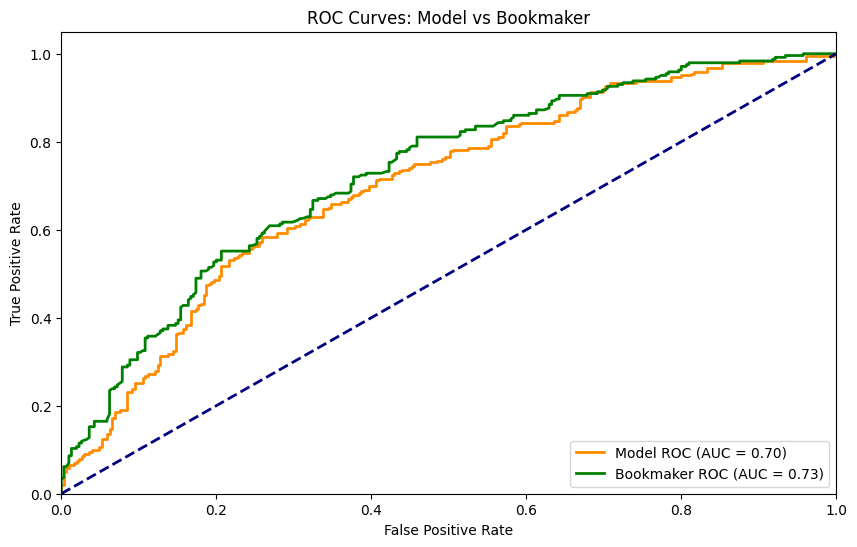


Sample Predictions vs Actuals:
      Actual_Result  Predicted_Result  Predicted_Home_Win_Prob  Home_Goals  \
365               0                 0                 0.200966           0   
393               0                 0                 0.425908           0   
1293              1                 0                 0.202009           1   
1350              1                 0                 0.470729           2   
2103              0                 1                 0.793863           1   
2271              1                 1                 0.755469           2   
2348              0                 0                 0.360518           2   
2233              1                 0                 0.275066           1   
650               1                 1                 0.504459           3   
298               1                 0                 0.276751           3   

      Away_Goals  Home_xG  Away_xG  Bookmaker_Home_Odds  Bookmaker_Draw_Odds  \
365            1      1.7    

In [189]:
# Prepare features and target
X = final_match_stats[[
    'home_rolling_goals', 'away_rolling_goals',
    'home_rolling_xg', 'away_rolling_xg',
    'goals_prior_home', 'goals_prior_away',
    'assists_prior_home', 'assists_prior_away', 
    'xG_prior_home', 'xG_prior_away',
    'xA_prior_home', 'xA_prior_away',
    'passes_completed_prior_home', 'passes_completed_prior_away',
    'passes_attempted_prior_home', 'passes_attempted_prior_away',
    'progressive_passes_prior_home', 'progressive_passes_prior_away',
    'carries_prior_home', 'carries_prior_away',
    'progressive_carries_prior_home', 'progressive_carries_prior_away',
    'successful_dribbles_prior_home', 'successful_dribbles_prior_away',
    'dribbles_attempted_prior_home', 'dribbles_attempted_prior_away',
    'appearances_home', 'appearances_away'
]].fillna(0)

y = final_match_stats['result']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Create evaluation dataframe
eval_df = pd.DataFrame({
    'Actual_Result': y_test,
    'Predicted_Result': y_pred,
    'Predicted_Home_Win_Prob': y_pred_proba[:, 1],
    'Home_Goals': final_match_stats.loc[y_test.index, 'home_goals'],
    'Away_Goals': final_match_stats.loc[y_test.index, 'away_goals'],
    'Home_xG': final_match_stats.loc[y_test.index, 'home_xG'],
    'Away_xG': final_match_stats.loc[y_test.index, 'away_xG'],
    'Bookmaker_Home_Odds': final_match_stats.loc[y_test.index, 'B365H'],
    'Bookmaker_Draw_Odds': final_match_stats.loc[y_test.index, 'B365D'],
    'Bookmaker_Away_Odds': final_match_stats.loc[y_test.index, 'B365A']
})

# Convert odds to probabilities
eval_df['Bookmaker_Home_Prob'] = 1 / eval_df['Bookmaker_Home_Odds']
eval_df['Bookmaker_Draw_Prob'] = 1 / eval_df['Bookmaker_Draw_Odds']
eval_df['Bookmaker_Away_Prob'] = 1 / eval_df['Bookmaker_Away_Odds']

# Normalize probabilities to sum to 1
prob_cols = ['Bookmaker_Home_Prob', 'Bookmaker_Draw_Prob', 'Bookmaker_Away_Prob']
eval_df[prob_cols] = eval_df[prob_cols].div(eval_df[prob_cols].sum(axis=1), axis=0)

# Print overall metrics
print("Model Performance Metrics:")
print("-------------------------")
print(f"Accuracy: {accuracy_score(eval_df['Actual_Result'], eval_df['Predicted_Result']):.3f}")
print("\nClassification Report:")
print(classification_report(eval_df['Actual_Result'], eval_df['Predicted_Result']))

# Compare model vs bookmaker predictions
print("\nAverage Predicted Probabilities:")
print(f"Model Home Win: {eval_df['Predicted_Home_Win_Prob'].mean():.3f}")
print(f"Bookmaker Home Win: {eval_df['Bookmaker_Home_Prob'].mean():.3f}")

# Plot ROC curves for both model and bookmaker
plt.figure(figsize=(10, 6))
# Model ROC
fpr_model, tpr_model, _ = roc_curve(eval_df['Actual_Result'], eval_df['Predicted_Home_Win_Prob'])
roc_auc_model = auc(fpr_model, tpr_model)
plt.plot(fpr_model, tpr_model, color='darkorange', lw=2, 
         label=f'Model ROC (AUC = {roc_auc_model:.2f})')

# Bookmaker ROC
fpr_bookie, tpr_bookie, _ = roc_curve(eval_df['Actual_Result'], eval_df['Bookmaker_Home_Prob'])
roc_auc_bookie = auc(fpr_bookie, tpr_bookie)
plt.plot(fpr_bookie, tpr_bookie, color='green', lw=2,
         label=f'Bookmaker ROC (AUC = {roc_auc_bookie:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Model vs Bookmaker')
plt.legend(loc="lower right")
plt.show()

# Display sample of predictions vs actuals
print("\nSample Predictions vs Actuals:")
print(eval_df.head(10))


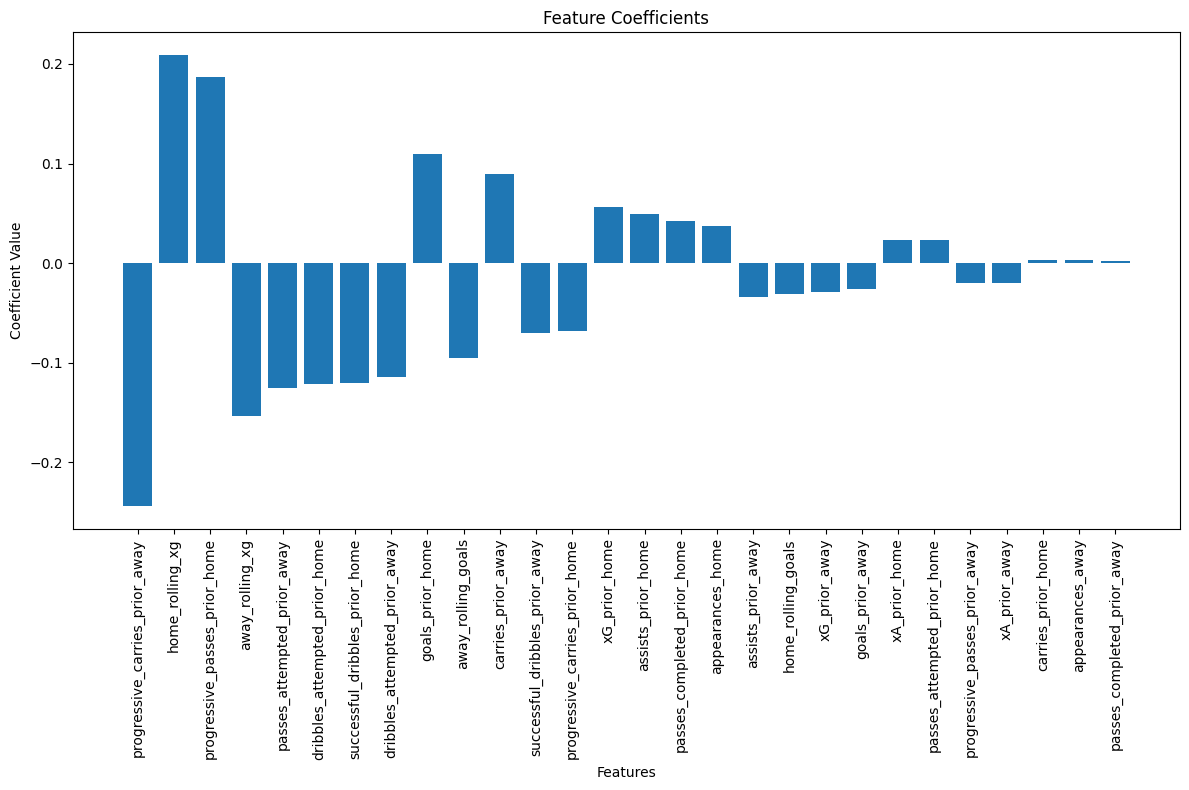


Top 10 Most Important Features:
                           feature  coefficient
21  progressive_carries_prior_away    -0.243729
2                  home_rolling_xg     0.208994
16   progressive_passes_prior_home     0.186526
3                  away_rolling_xg    -0.153165
15     passes_attempted_prior_away    -0.125057
24   dribbles_attempted_prior_home    -0.121456
22  successful_dribbles_prior_home    -0.120075
25   dribbles_attempted_prior_away    -0.113852
4                 goals_prior_home     0.109986
1               away_rolling_goals    -0.094858


In [190]:
# Get feature coefficients and sort by absolute value
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
feature_importance['abs_coef'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importance)), feature_importance['coefficient'])
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=90)
plt.title('Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance[['feature', 'coefficient']].head(10))


In [191]:
eval_df.to_csv('../../data/outputs/model_predictions.csv', index=False)
